<a href="https://colab.research.google.com/github/Hanifahmed/wind_analysis_project/blob/main/Wind_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install windrose

Columns in your dataframe: Index(['wind_speed_10m', 'u10', 'v10', 'temp_2m', 'msl_pressure'], dtype='object')
Weibull shape (k): 3.41, scale (c): 4.73 m/s


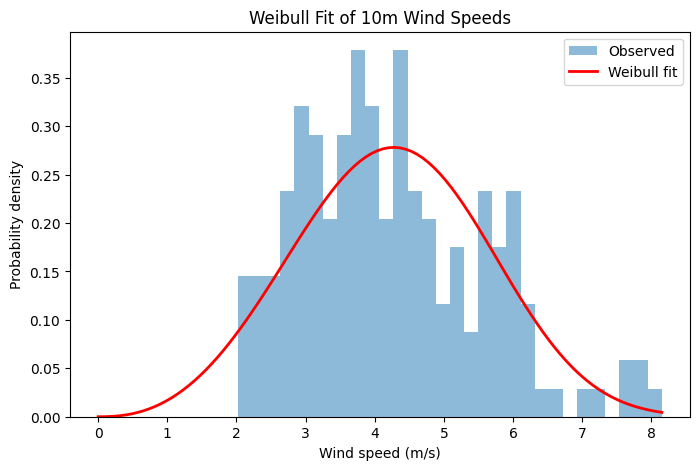

Mean cubic wind speed: 101.21 (m/s)^3
Wind Power Density: 62.0 W/m²
Expected mean power output: 139.5 kW
Annual Energy Production: 1221.9 MWh/year
Capacity Factor: 7.0%

Comparison Table:
   Hub Height      Turbine  Mean Power (kW)  AEP (MWh)  CF (%)
0          50  Generic 2MW            102.2      895.6     5.1
1          50  Generic 3MW            218.2     1911.1     7.3
2          80  Generic 2MW            139.5     1221.9     7.0
3          80  Generic 3MW            296.9     2600.8     9.9
4         100  Generic 2MW            160.0     1401.4     8.0
5         100  Generic 3MW            339.8     2976.5    11.3


/tmp/ipython-input-1143394098.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  E_mean = np.trapz(power_curve * pdf, V)  # kW
/tmp/ipython-input-1143394098.py:113: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  E_mean = np.trapz(power_curve * weibull_min.pdf(V, k, scale=V_hub_scaled), V)


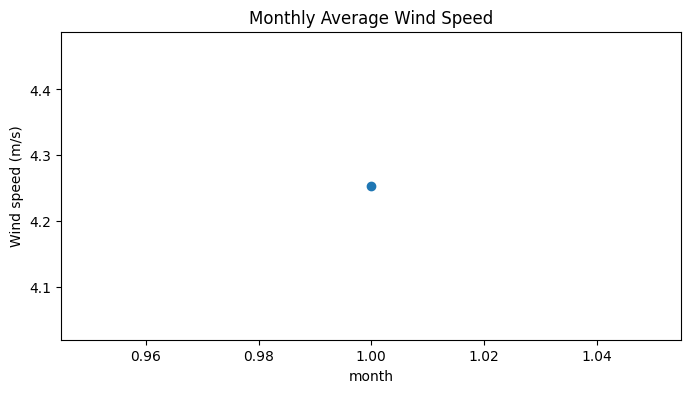

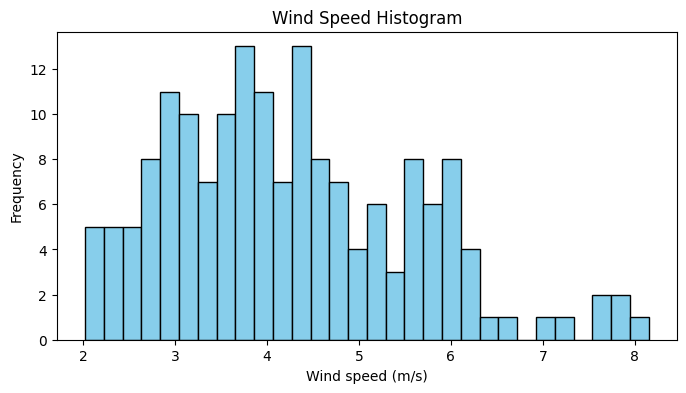

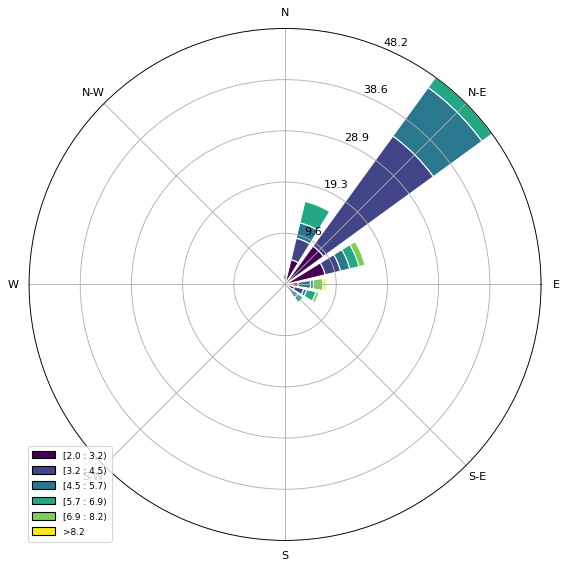

In [22]:
# ================================
# 1️⃣ Imports
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from scipy.special import gamma

# Optional for wind rose
# !pip install windrose
from windrose import WindroseAxes

# ================================
# 2️⃣ Load / Check Data
# ================================
# Replace this with your ERA5 extraction
# df_site must have: 'wind_speed_10m', 'u10', 'v10', optional: 'temp_2m', 'msl_pressure'
print("Columns in your dataframe:", df_site.columns)

# Ensure time index exists for seasonal analysis
if not pd.api.types.is_datetime64_any_dtype(df_site.index):
    df_site.index = pd.to_datetime(df_site.index)

# ================================
# 3️⃣ Weibull Fitting
# ================================
wind_data = df_site["wind_speed_10m"].dropna().values

# Fit Weibull distribution
params = weibull_min.fit(wind_data, floc=0)
k, loc, c = params

print(f"Weibull shape (k): {k:.2f}, scale (c): {c:.2f} m/s")

# Plot histogram + Weibull PDF
x = np.linspace(0, wind_data.max(), 100)
pdf_fitted = weibull_min.pdf(x, k, loc, c)

plt.figure(figsize=(8,5))
plt.hist(wind_data, bins=30, density=True, alpha=0.5, label="Observed")
plt.plot(x, pdf_fitted, 'r-', lw=2, label="Weibull fit")
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Probability density")
plt.legend()
plt.title("Weibull Fit of 10m Wind Speeds")
plt.show()

# ================================
# 4️⃣ Wind Power Density (WPD)
# ================================
rho = 1.225  # air density kg/m³
V3_mean = c**3 * gamma(1 + 3/k)
WPD = 0.5 * rho * V3_mean

print(f"Mean cubic wind speed: {V3_mean:.2f} (m/s)^3")
print(f"Wind Power Density: {WPD:.1f} W/m²")

# ================================
# 5️⃣ Turbine Power Curve & Mean Power
# ================================
def scale_wind_to_hub(V10, hub_height, z0=0.03):
    return V10 * (np.log(hub_height/z0)/np.log(10/z0))

def turbine_power_curve(V, P_rated=2000, V_ci=3, V_r=12, V_co=25):
    P = np.piecewise(
        V,
        [V < V_ci, (V >= V_ci) & (V < V_r), (V >= V_r) & (V <= V_co), V > V_co],
        [0, lambda V: P_rated*((V - V_ci)/(V_r - V_ci))**3, P_rated, 0]
    )
    return P

hub_height = 80  # default hub height
V_hub = c * (np.log(hub_height/0.03)/np.log(10/0.03))  # scaled Weibull scale

V = np.linspace(0, 30, 1000)
pdf = weibull_min.pdf(V, k, scale=V_hub)
power_curve = turbine_power_curve(V)
E_mean = np.trapz(power_curve * pdf, V)  # kW

print(f"Expected mean power output: {E_mean:.1f} kW")

# ================================
# 6️⃣ Annual Energy Production & Capacity Factor
# ================================
hours_per_year = 8760
AEP = E_mean * hours_per_year  # kWh/year
P_rated = 2000  # kW
CF = E_mean / P_rated

print(f"Annual Energy Production: {AEP/1000:.1f} MWh/year")
print(f"Capacity Factor: {CF*100:.1f}%")

# ================================
# 7️⃣ Comparison: Hub Heights & Turbine Models
# ================================
hub_heights = [50, 80, 100]  # m
turbines = [
    {"name":"Generic 2MW","P_rated":2000,"V_ci":3,"V_r":12,"V_co":25},
    {"name":"Generic 3MW","P_rated":3000,"V_ci":3,"V_r":11,"V_co":25}
]

results = []
for h in hub_heights:
    V_hub_scaled = c * (np.log(h/0.03)/np.log(10/0.03))
    for turb in turbines:
        # Only pass parameters that turbine_power_curve expects
        power_curve = turbine_power_curve(V,
                                          P_rated=turb["P_rated"],
                                          V_ci=turb["V_ci"],
                                          V_r=turb["V_r"],
                                          V_co=turb["V_co"])
        E_mean = np.trapz(power_curve * weibull_min.pdf(V, k, scale=V_hub_scaled), V)
        AEP = E_mean * hours_per_year
        CF = E_mean / turb["P_rated"]
        results.append({
            "Hub Height": h,
            "Turbine": turb["name"],
            "Mean Power (kW)": round(E_mean,1),
            "AEP (MWh)": round(AEP/1000,1),
            "CF (%)": round(CF*100,1)
        })

results_df = pd.DataFrame(results)
print("\nComparison Table:")
print(results_df)

# ================================
# 8️⃣ Extra Analysis
# ================================
# a) Seasonal average
df_site['month'] = df_site.index.month
seasonal_avg = df_site.groupby('month')["wind_speed_10m"].mean()
seasonal_avg.plot(marker='o', figsize=(8,4), title="Monthly Average Wind Speed")
plt.ylabel("Wind speed (m/s)")
plt.show()

# b) Histogram
plt.figure(figsize=(8,4))
plt.hist(df_site["wind_speed_10m"], bins=30, color="skyblue", edgecolor="k")
plt.title("Wind Speed Histogram")
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Frequency")
plt.show()

# c) Optional: Wind rose
try:
    u = df_site['u10'].values
    v = df_site['v10'].values
    ws = np.sqrt(u**2 + v**2)
    wd = (180/np.pi) * np.arctan2(u, v)  # wind direction from north

    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.show()
except:
    print("Wind rose skipped (u10/v10 not available or windrose not installed)")